<a href="https://colab.research.google.com/github/RVaishnavi12/Musicology/blob/main/Musicology_first_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Generate music with an RNN

## Setup

`pretty_midi` library is used to create and parse MIDI files, and `pyfluidsynth` is used for generating audio playback in Colab.

In [2]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 21 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/unive

In [3]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 34.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 7.3 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=4ec7471670f7c452e6e1ffcf736564c2203344e36d68b6faf89f008a1b8c0a93
  Stored in directory: /root/.cache/pip/wheels/2a/5a/e3/30eeb9a99350f3f7e21258fcb132743eef1a4f49b3505e76b6
Successfully built pretty_midi


In [5]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [6]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [8]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 0s 0us/step


The dataset contains about 1,200 MIDI files.

In [9]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

 ```pretty_midi``` is used to parse a single MIDI file and inspect the format of the notes.


In [58]:
!wget("https://storage.googleapis.com/magentadata/datasets/groove/groove-v1.0.0.zip")

/bin/bash: -c: line 0: syntax error near unexpected token `"https://storage.googleapis.com/magentadata/datasets/groove/groove-v1.0.0.zip"'
/bin/bash: -c: line 0: `wget("https://storage.googleapis.com/magentadata/datasets/groove/groove-v1.0.0.zip")'


In [11]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2008/MIDI-Unprocessed_09_R2_2008_01-05_ORIG_MID--AUDIO_09_R2_2008_wav--3.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [12]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. (The playback widget may take several seconds to load.)

In [13]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [14]:
display_audio(pm)

Identify the kinds of instrument(s) used.

In [15]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [16]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=58, note_name=A#3, duration=0.3516
1: pitch=46, note_name=A#2, duration=0.3346
2: pitch=47, note_name=B2, duration=0.2018
3: pitch=59, note_name=B3, duration=0.2799
4: pitch=45, note_name=A2, duration=0.2031
5: pitch=57, note_name=A3, duration=0.3151
6: pitch=46, note_name=A#2, duration=0.3359
7: pitch=58, note_name=A#3, duration=0.3516
8: pitch=51, note_name=D#3, duration=0.5690
9: pitch=39, note_name=D#2, duration=0.5508


Three variables are used to represent a note when training the model: `pitch`, `step` and `duration`. 
*   The `pitch` is the perceptual quality of the sound as a MIDI note number. 
*   The `step` is the time elapsed from the previous note or start of the track.
*   The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.

Extract the notes from the sample MIDI file.

In [17]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [18]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     58  0.997396  1.348958  0.000000  0.351562
1     46  1.037760  1.372396  0.040365  0.334635
2     59  1.252604  1.532552  0.214844  0.279948
3     47  1.311198  1.513021  0.058594  0.201823
4     57  1.489583  1.804688  0.178385  0.315104

It is easier to interpret the note names rather than the pitches, so the function below is used to convert from the numeric pitch values to note names. 
The note name shows the type of note, accidental and octave number
(e.g. C#4). 

In [19]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['A#3', 'A#2', 'B3', 'B2', 'A3', 'A2', 'A#2', 'A#3', 'D#3', 'D#2'],
      dtype='<U3')

Plot the note pitch, start and end across the length of the track(i.e. piano roll) to visualize the musical piece. 
Start with the first 100 notes

In [20]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [21]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

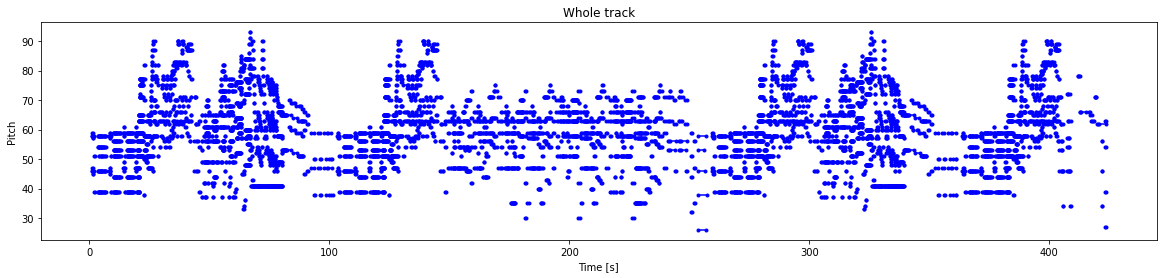

In [22]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [23]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

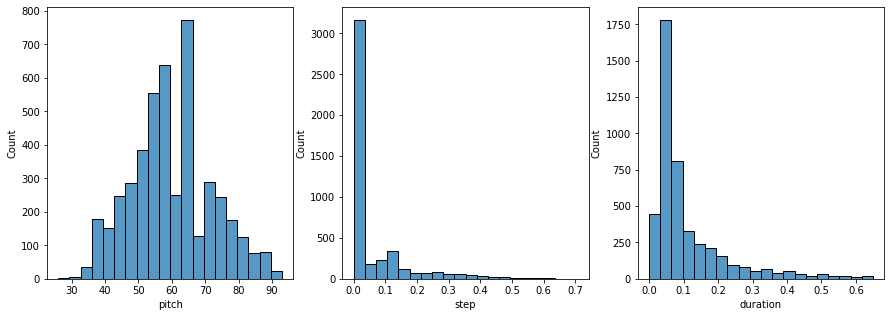

In [24]:
plot_distributions(raw_notes)

## Create a MIDI file

Generate your own MIDI file from a list of notes.

In [25]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write("/content/drive/MyDrive/Colab Notebooks/Test/"+out_file)
  return pm

In [26]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [27]:
display_audio(example_pm)

## Create the training dataset

Training dataset is created by extracting notes from the MIDI files.

In [28]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [30]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 15780


A `tf.data.Dataset` is created from the parsed notes.

In [31]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [32]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

The model is trained on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence.

In [33]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [34]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [35]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.4921875  0.         0.91796875]
 [0.5        0.85546875 0.21484375]
 [0.4921875  0.4609375  0.24348958]
 [0.53125    0.1484375  0.33072917]
 [0.5546875  0.01302083 0.83072917]
 [0.484375   0.00911458 0.41666667]
 [0.546875   0.68880208 0.39453125]
 [0.4765625  0.         0.40104167]
 [0.5234375  0.0078125  0.34765625]
 [0.3046875  0.         1.00651042]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=68.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.8346354166666661>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.9661458333333339>}


Batch the examples, and configure the dataset for performance.

In [36]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [37]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, a custom loss function is used based on mean squared error that encourages the model to output non-negative values.

In [38]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [39]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

The `pitch` loss is significantly greater than the `step` and `duration` losses this can be seen by testing the `model.evaluate` function. 
`loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [40]:
losses = model.evaluate(train_ds, return_dict=True)
losses

246/246 [==============================] - 8s 6ms/step - loss: 5.1894 - duration_loss: 0.2606 - pitch_loss: 4.8450 - step_loss: 0.0837


{'loss': 5.189396381378174,
 'duration_loss': 0.26063254475593567,
 'pitch_loss': 4.845045566558838,
 'step_loss': 0.08371872454881668}

`loss_weights` argument to compile is a way to balance this.

In [41]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [42]:
model.evaluate(train_ds, return_dict=True)

246/246 [==============================] - 2s 4ms/step - loss: 0.5866 - duration_loss: 0.2606 - pitch_loss: 4.8450 - step_loss: 0.0837


{'loss': 0.5866037011146545,
 'duration_loss': 0.26063254475593567,
 'pitch_loss': 4.845045566558838,
 'step_loss': 0.08371872454881668}

##Train the model.

In [43]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [44]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
246/246 [==============================] - 5s 7ms/step - loss: 0.3494 - duration_loss: 0.1065 - pitch_loss: 4.0871 - step_loss: 0.0385
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.3356 - duration_loss: 0.1024 - pitch_loss: 3.9143 - step_loss: 0.0374
Epoch 3/50
246/246 [==============================] - 2s 10ms/step - loss: 0.3280 - duration_loss: 0.0994 - pitch_loss: 3.8289 - step_loss: 0.0371
Epoch 4/50
246/246 [==============================] - 3s 10ms/step - loss: 0.3202 - duration_loss: 0.0980 - pitch_loss: 3.7160 - step_loss: 0.0364
Epoch 5/50
246/246 [==============================] - 3s 10ms/step - loss: 0.3172 - duration_loss: 0.0966 - pitch_loss: 3.6853 - step_loss: 0.0363
Epoch 6/50
246/246 [==============================] - 3s 12ms/step - loss: 0.3146 - duration_loss: 0.0963 - pitch_loss: 3.6540 - step_loss: 0.0356
Epoch 7/50
246/246 [==============================] - 2s 8ms/step - loss: 0.3128 - duration_loss: 0.0954 - pitch_loss: 3

In [48]:
model.save("/content/drive/MyDrive/Colab Notebooks/SaveModels/model")

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [56]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/SaveModels/model', custom_objects={"mse_with_positive_pressure":mse_with_positive_pressure})

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

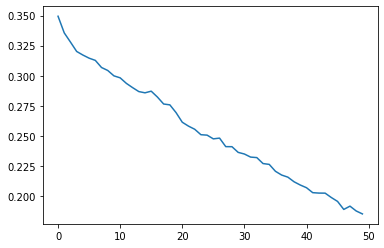

In [45]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

In [42]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes - `next_notes`.

In [43]:
def notesGenerator(temperature, num_predictions, raw_notes):

  temperature = 2.0
  num_predictions = 120

  sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

  # The initial sequence of notes; pitch is normalized similar to training
  # sequences
  input_notes = (
      sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

  generated_notes = []
  prev_start = 0
  for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

  generated_notes = pd.DataFrame(
      generated_notes, columns=(*key_order, 'start', 'end'))
  
  return generated_notes
  
def saveAndGenerateMIDI(generated_notes,instrument_name="Acoustic Grand Piano", out_file = 'output.mid'):
  # if out_file.split('.')
  out_pm = notes_to_midi(
      generated_notes, out_file=out_file, instrument_name=instrument_name)
  return out_pm


Save and generate MIDI(generated_notes)



In [44]:
import random

# temperature, num_predictions = map(int,input("input Temprature and number of predictions to generate: ").split())
temperature, num_predictions = map(int,("20 52").split())

# raw_notes = midi_to_notes(sample_file)

while True:

  #generate notes from random file from filenames 
  random_file = filenames[random.randrange(len(filenames))]
  raw_notes = midi_to_notes(random_file)
  print(random_file)

  # Create a function to view audio file in while loop or Function
  display_audio(saveAndGenerateMIDI(raw_notes)) #does not display audio

  user_choice = input("do you wnat to generate notes from above file: ").lower()



  if user_choice == "yes":
    generated_notes = notesGenerator(temperature, num_predictions,raw_notes)
    break
  elif user_choice == "no":
    continue
  else:
    print("Please provide valid output")

display_audio(saveAndGenerateMIDI(generated_notes))



data/maestro-v2.0.0/2013/ORIG-MIDI_03_7_10_13_Group_MID--AUDIO_17_R3_2013_wav--1.midi
do you wnat to generate notes from above file: yes
1/1 [==============================] - 0s 18ms/step


In [45]:
# generate n number of random audio files

import random

temperature, num_predictions = map(int,("20 52").split())


# raw_notes = midi_to_notes(sample_file)
n=10
for _ in range(n):

  #generate notes from random file from filenames 
  random_file = filenames[random.randrange(len(filenames))]
  raw_notes = midi_to_notes(random_file)
  print(random_file)

  # Create a function to view audio file in while loop or Function
  display_audio(saveAndGenerateMIDI(raw_notes)) #does not display audio



  generated_notes = notesGenerator(temperature, num_predictions,raw_notes)
  

  display_audio(saveAndGenerateMIDI(generated_notes, out_file=f"generatedAudio{_}"))






data/maestro-v2.0.0/2008/MIDI-Unprocessed_02_R3_2008_01-03_ORIG_MID--AUDIO_02_R3_2008_wav--2.midi
1/1 [==============================] - 0s 21ms/step
data/maestro-v2.0.0/2009/MIDI-Unprocessed_05_R1_2009_03-05_ORIG_MID--AUDIO_05_R1_2009_05_R1_2009_03_WAV.midi
1/1 [==============================] - 0s 19ms/step
data/maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_19_R1_2015_wav--4.midi
1/1 [==============================] - 0s 20ms/step
data/maestro-v2.0.0/2017/MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--1.midi
1/1 [==============================] - 0s 26ms/step
data/maestro-v2.0.0/2013/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--4.midi
1/1 [==============================] - 0s 22ms/step
data/maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_13_R1_2015_wav--5.midi
1/1 [==============================] - 0s 20ms/step
data/maestro-v2.0.0/2006/MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_07_Track0

In [46]:
!pip freeze >req.txt

In [47]:
generated_notes.head(10)

pitch      step  duration     start       end
0     76  0.049600  0.073709  0.049600  0.123309
1     86  0.210337  0.760572  0.259937  1.020509
2     82  0.250944  0.835455  0.510881  1.346336
3     87  0.252141  0.825474  0.763022  1.588496
4     86  0.245155  0.797914  1.008177  1.806091
5     80  0.242785  0.795188  1.250963  2.046151
6     99  0.246202  0.799490  1.497165  2.296655
7     86  0.240469  0.790900  1.737633  2.528533
8     79  0.254981  0.832642  1.992614  2.825256
9     82  0.253802  0.814261  2.246416  3.060678

In [48]:
def saveAndGenerateMIDI(generated_notes,instrument_name="Acoustic Grand Piano", out_file = 'output.mid'):
  out_pm = notes_to_midi(
      generated_notes, out_file=out_file, instrument_name=instrument_name)
  return out_pm

display_audio(saveAndGenerateMIDI(generated_notes))

In [49]:
import os
test_dir = r"/content/drive/MyDrive/Colab Notebooks/Test"
test_file = test_dir + "test1.wav"
for file in os.listdir(test_dir):
  print(file)
  pred = nearestClass(getNeighbors(dataset, feature_generation(test_dir+file), 5))
  print(results[pred])

test2.wav


NameError: ignored

Visualize the generated notes.

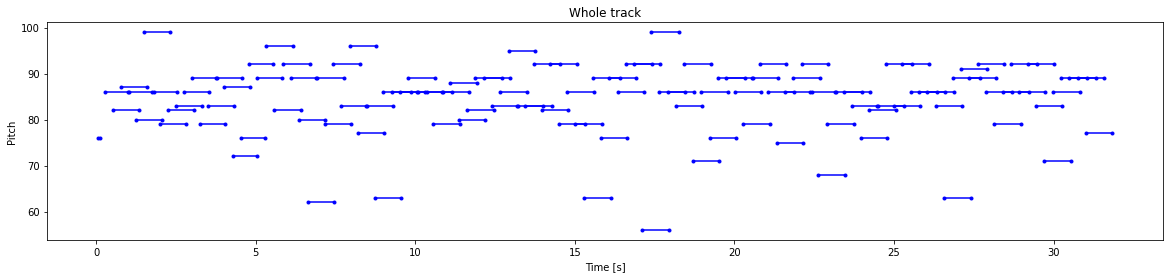

In [50]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

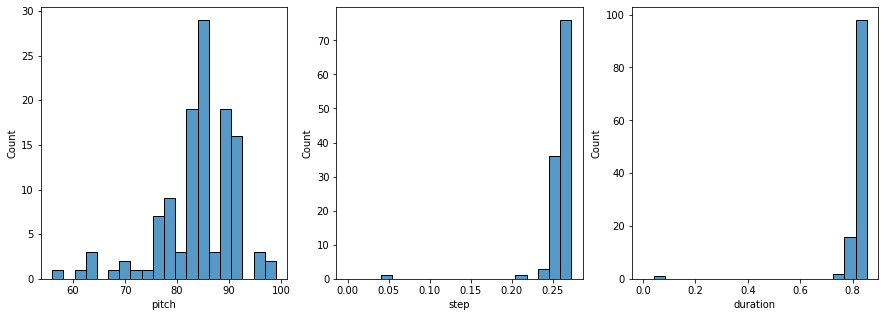

In [51]:
plot_distributions(generated_notes)

In [52]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
# convert midi to wav
from pydub import AudioSegment
from pydub.generators import Sine

# Load the MIDI file
midi = AudioSegment.from_file("/content/generatedAudio2.mid", format="mid")

# Generate a sine wave tone to be used as the backing track
backing_track = Sine(440).to_audio_segment(duration=midi.duration_seconds)

# Mix the backing track and the MIDI file
mixed = midi.overlay(backing_track)

# Save the mixed audio as a WAV file
mixed.export("output.wav", format="wav")

SyntaxError: ignored

In [54]:
import pygame

def midi_to_wav(midi_filename, wav_filename):
    """
    Convert a MIDI file to a WAV file.
    """
    pygame.init()
    pygame.mixer.music.load(midi_filename)
    pygame.mixer.music.set_endevent(pygame.USEREVENT)
    pygame.mixer.music.play()
    while True:
        events = pygame.event.get()
        for event in events:
            if event.type == pygame.USEREVENT:
                pygame.mixer.music.save(wav_filename)
                return

# Example usage:
midi_to_wav("input.mid", "output.wav")

SyntaxError: ignored

In [55]:
# convert Midi to wav
!apt install fluidsynth
!wget https://github.com/FluidSynth/fluid-soundfont/releases/download/v3.1/FluidR3_GM.sf2 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (2.1.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
--2023-02-17 17:01:46--  https://github.com/FluidSynth/fluid-soundfont/releases/download/v3.1/FluidR3_GM.sf2
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-17 17:01:46 ERROR 404: Not Found.



In [56]:
import subprocess

def midi_to_wav(midi_filename, wav_filename):
    """
    Convert a MIDI file to a WAV file using FluidSynth.
    """
    subprocess.call(['fluidsynth', '-F', wav_filename, '-ni', 'FluidR3_GM.sf2', midi_filename])

midi_to_wav("/content/generatedAudio7.midi", "/content/wav_file.wav")

In [ ]:
!pip install midi2audio
!pip install mido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 4.0 MB/s eta 0:00:00


In [ ]:
from midi2audio import FluidSynth
# Play MIDI:
FluidSynth().midi_to_audio('/content/generatedAudio2.mid', 'output.wav')
# FluidSynth().play_midi('input.mid')

FileNotFoundError: ignored

In [ ]:
from collections import defaultdict
from mido import MidiFile
from pydub import AudioSegment
from pydub.generators import Sine

def note_to_freq(note, concert_A=440.0):
  '''
  from wikipedia: http://en.wikipedia.org/wiki/MIDI_Tuning_Standard#Frequency_values
  '''
  return (2.0 ** ((note - 69) / 12.0)) * concert_A

mid = MidiFile("/content/generatedAudio2")
print(type(mid))
output = AudioSegment.silent(mid.length * 1000.0)

tempo = 100 # bpm

def ticks_to_ms(ticks):
  tick_ms = (60000.0 / tempo) / mid.ticks_per_beat
  return ticks * tick_ms
  

for track in mid.tracks:
  # position of rendering in ms
  current_pos = 0.0

  current_notes = defaultdict(dict)
  # current_notes = {
  #   channel: {
  #     note: (start_time, message)
  #   }
  # }
  
  for msg in track:
    current_pos += ticks_to_ms(msg.time)

    if msg.type == 'note_on':
      current_notes[msg.channel][msg.note] = (current_pos, msg)
    
    if msg.type == 'note_off':
      start_pos, start_msg = current_notes[msg.channel].pop(msg.note)
  
      duration = current_pos - start_pos
  
      signal_generator = Sine(note_to_freq(msg.note))
      rendered = signal_generator.to_audio_segment(duration=duration-50, volume=-20).fade_out(100).fade_in(30)

      output = output.overlay(rendered, start_pos)

output.export("animal2.wav", format="wav")

FileNotFoundError: ignored

In [ ]:
from midi2audio import FluidSynth
# Play MIDI:
FluidSynth().midi_to_audio('/content/generatedAudio2.mid', 'output.wav')
# FluidSynth().play_midi('input.mid')

FileNotFoundError: ignored

In [ ]:
type(pm)

pretty_midi.pretty_midi.PrettyMIDI